In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_roi_coordinates(src):
    """
    :param src: The image to be transformed
    :return: ROI coordinates in the transformed image
    """
    h, w = src.shape
    coordinates_list = []

    for i in range(h):
        for j in range(w):
            if src[i, j] != 0:
                coordinates_list.append((i, j))

    return coordinates_list


def get_max_min_coordinates(roi_coordinates, M):
    """
    :param roi_coordinates: roi 좌표
    :param M: 변환 행렬
    :return: 변환된 좌표 값들의 최댓값 및 최솟값
    """
    # dst shape 구하기
    cor_transform = []
    for coord in roi_coordinates:
        transformed_coord = np.dot(M, [coord[1], coord[0], 1]) 
        transformed_coord /= transformed_coord[2] 
        cor_transform.append(transformed_coord[:2])  

    cor_transform = np.array(cor_transform)


    row_max = np.max(cor_transform[:, 1])
    row_min = np.min(cor_transform[:, 1])
    col_max = np.max(cor_transform[:, 0])
    col_min = np.min(cor_transform[:, 0])

    return row_max, row_min, col_max, col_min

In [3]:
def backward(src, M):
    """
    :param src: 변환 시킬 이미지
    :param M: 변환 행렬
    :return: dst: 크기가 보정된 변환 이미지
    """
    print('\n< backward >')
    print('M')
    print(M)

    h, w = src.shape
    # M 역행렬 구하기
    M_inv = np.linalg.inv(M)
    print('M inv')
    print(M_inv)

    # 중복 제거
    roi_coordinates = list(set(get_roi_coordinates(src)))

    (row_max, row_min, col_max, col_min) = get_max_min_coordinates(roi_coordinates, M)
    print(row_max, row_min, col_max, col_min)

    h_ = int(row_max - row_min + 1)
    w_ = int(col_max - col_min + 1)
    dst = np.zeros((h_, w_))

    for row in range(h_):
        for col in range(w_):
            P_dst = np.array([col_min + col, row_min + row, 1])

            # original 좌표로 매핑
            P = np.dot(M_inv, P_dst)
            src_col = P[0]
            src_row = P[1]

            src_col_right = int(np.ceil(src_col))
            src_col_left = int(src_col)

            src_row_bottom = int(np.ceil(src_row))
            src_row_top = int(src_row)

            # index를 초과하는 부분에 대해서는 값을 채우지 않음
            if src_col_right >= w or src_row_bottom >= h or src_col_left < 0 or src_row_top < 0:
                continue

            s = src_col - src_col_left
            s = np.clip(s, 0, 1)
            t = src_row - src_row_top
            t = np.clip(t, 0, 1)

            intensity = (1 - s) * (1 - t) * src[src_row_top, src_col_left] \
                            + s * (1 - t) * src[src_row_top, src_col_right] \
                            + (1 - s) * t * src[src_row_bottom, src_col_left] \
                            + s * t * src[src_row_bottom, src_col_right]

            dst[row, col] = intensity

    dst = dst.astype(np.uint8)

    print('dst shape : {}'.format(dst.shape))
    print('dst min : {} dst max : {}'.format(np.min(dst), np.max(dst)))

    return dst

In [4]:
def generate_rotation(degree):
    radian = np.deg2rad(degree)
    cos_theta = np.cos(radian)
    sin_theta = np.sin(radian)
    M_ro = np.array([[cos_theta, -sin_theta, 0],
                     [sin_theta, cos_theta, 0],
                     [0, 0, 1]])
    return M_ro

def generate_scaling(x_scaling, y_scaling):
    M_sc = np.array([[x_scaling, 0, 0],
                     [0, y_scaling, 0],
                     [0, 0, 1]])
    return M_sc

def generate_shearing(x, y):
    M_sh = np.array([[1, x, 0],
                     [y, 1, 0],
                     [0, 0, 1]])
    return M_sh

In [5]:
def display_image(image_list):
    template = np.zeros((850,800))
    template = cv2.line(template, (0, 25), (800, 25), (0.5, 0.5, 0.5))
    template = cv2.line(template, (0, 425), (800, 425), (0.5, 0.5, 0.5))
    template = cv2.line(template, (0, 450), (800, 450), (0.5, 0.5, 0.5))
    template = cv2.line(template, (400, 0), (400, 850), (0.5, 0.5, 0.5))

    template = cv2.putText(template, 'step 1 rotation', (100, 18), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255,0,0), 1,
                           cv2.LINE_4)
    template = cv2.putText(template, 'step 2 shear', (525, 18), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 1,
                           cv2.LINE_4)
    template = cv2.putText(template, 'step 3 scale', (100, 425 + 18), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 1,
                           cv2.LINE_4)
    template = cv2.putText(template, 'final image', (525, 425 + 18), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 1,
                           cv2.LINE_4)

    template[26:424, 1:399] = 255
    template[26:424, 401:799] = 255
    template[451:849, 1:399] = 255
    template[451:849, 401:799] = 255

    # first_image
    first_image = image_list[0] 
    first_image_shape = first_image.shape
    coord_1 = (400 - first_image_shape[0]) // 2
    coord_2 = (400 - first_image_shape[1]) // 2
    template[25 + coord_1 : 25 + first_image_shape[0] + coord_1,  coord_2 : first_image_shape[1] + coord_2] = first_image

    if len(image_list) == 2:
        second_image = image_list[1] 
        second_image_shape = second_image.shape
        coord_1 = (400 - second_image_shape[0]) // 2
        coord_2 = (400 - second_image_shape[1]) // 2
        coord_2 += 400
        template[25 + coord_1: 25 + second_image_shape[0] + coord_1,
        coord_2: second_image_shape[1] + coord_2] = second_image

    if len(image_list) == 3:
        second_image = image_list[1]
        second_image_shape = second_image.shape
        coord_1 = (400 - second_image_shape[0]) // 2
        coord_2 = (400 - second_image_shape[1]) // 2
        coord_2 += 400
        template[25 + coord_1: 25 + second_image_shape[0] + coord_1,
        coord_2: second_image_shape[1] + coord_2] = second_image

        third_image = image_list[2]
        third_image_shape = third_image.shape
        coord_1 = (400 - third_image_shape[0]) // 2
        coord_2 = (400 - third_image_shape[1]) // 2
        coord_1 += 425
        template[25 + coord_1: 25 + third_image_shape[0] + coord_1,
        coord_2: third_image_shape[1] + coord_2] = third_image

    if len(image_list) == 4:

        second_image = image_list[1] 
        second_image_shape = second_image.shape
        coord_1 = (400 - second_image_shape[0]) // 2
        coord_2 = (400 - second_image_shape[1]) // 2
        coord_2 += 400
        template[25 + coord_1: 25 + second_image_shape[0] + coord_1,
        coord_2: second_image_shape[1] + coord_2] = second_image

        third_image = image_list[2]
        third_image_shape = third_image.shape
        coord_1 = (400 - third_image_shape[0]) // 2
        coord_2 = (400 - third_image_shape[1]) // 2
        coord_1 += 425

        template[25 + coord_1: 25 + third_image_shape[0] + coord_1,
        coord_2: third_image_shape[1] + coord_2] = third_image

        final_image = image_list[3]
        final_image_shape = final_image.shape
        coord_1 = (400 - final_image_shape[0]) // 2
        coord_2 = (400 - final_image_shape[1]) // 2
        coord_1 += 425
        coord_2 += 400
        template[25 + coord_1: 25 + final_image_shape[0] + coord_1,
        coord_2: final_image_shape[1] + coord_2] = final_image

    plt.imshow(template, cmap='gray')
    plt.show()


< backward >
M
[[ 0.93969262 -0.34202014  0.        ]
 [ 0.34202014  0.93969262  0.        ]
 [ 0.          0.          1.        ]]
M inv
[[ 0.93969262  0.34202014  0.        ]
 [-0.34202014  0.93969262  0.        ]
 [ 0.          0.          1.        ]]
364.00642500768794 0.0 266.872704303198 -97.13372070448992
dst shape : (365, 365)
dst min : 0 dst max : 231


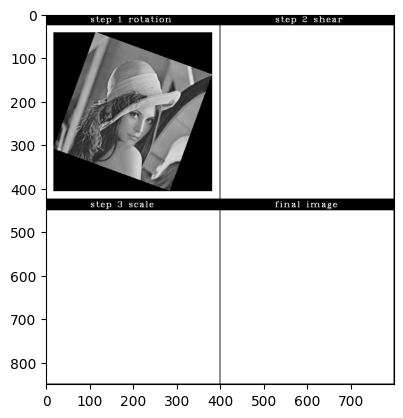


< backward >
M
[[1.  0.2 0. ]
 [0.2 1.  0. ]
 [0.  0.  1. ]]
M inv
[[ 1.04166667 -0.20833333  0.        ]
 [-0.20833333  1.04166667  0.        ]
 [ 0.          0.          1.        ]]
416.4 19.400000000000002 383.4 52.800000000000004
dst shape : (398, 331)
dst min : 0 dst max : 229


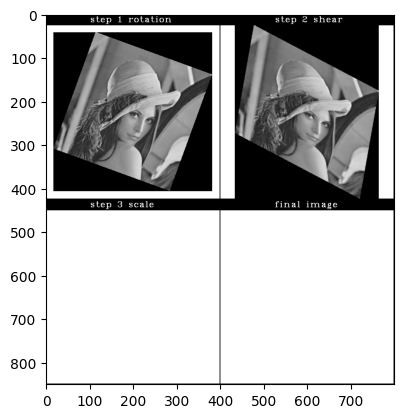


< backward >
M
[[0.75 0.   0.  ]
 [0.   0.75 0.  ]
 [0.   0.   1.  ]]
M inv
[[1.33333333 0.         0.        ]
 [0.         1.33333333 0.        ]
 [0.         0.         1.        ]]
297.75 0.0 247.5 0.0
dst shape : (298, 248)
dst min : 0 dst max : 227


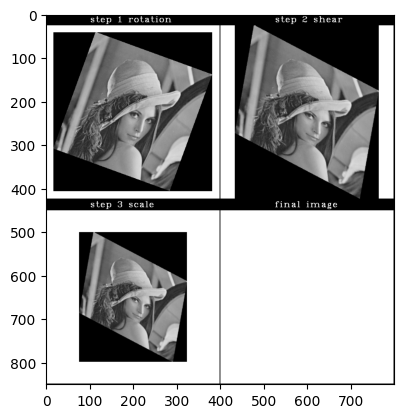


< backward >
M
[[ 0.75607249 -0.11556121  0.        ]
 [ 0.397469    0.65346644  0.        ]
 [ 0.          0.          1.        ]]
M inv
[[ 1.21012304  0.21400225  0.        ]
 [-0.7360537   1.40013424  0.        ]
 [ 0.          0.          1.        ]]
298.4656662955722 0.0 214.72458633307195 -32.81938488288773
dst shape : (299, 248)
dst min : 0 dst max : 231


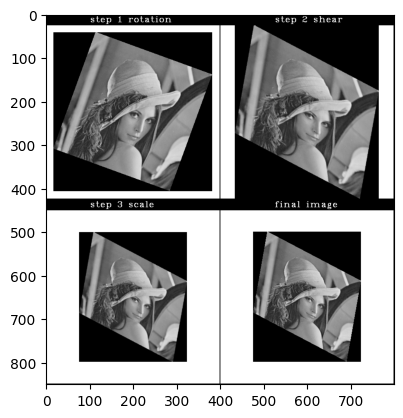

In [6]:
def main():

    src = cv2.imread('./Lena.png', cv2.IMREAD_GRAYSCALE)
    src = cv2.resize(src, (285, 285))

    ###########################################################
    # TODO
    # TODO M 완성
    # TODO M_tr, M_sc ... 등등 모든 행렬 M 완성하기
    # TODO 각 변환 행렬 행성 시 generate_xxxx 함수의 인자값을 참고하여 구현
    ###########################################################

    degree = 20
    # scaling
    M_sc = generate_scaling(0.75, 0.75)
    # rotation
    M_ro = generate_rotation(degree)
    # shearing
    M_sh = generate_shearing(0.2, 0.2)

    # rotation -> Shear -> Scale
    M = M_ro
    M = np.dot(M_sh, M)
    M = np.dot(M_sc, M)

    # backward step by step
    dst_back1 = backward(src, M_ro)
    display_image([dst_back1])   
    
    dst_back2 = backward(dst_back1, M_sh)
    display_image([dst_back1,dst_back2])

    dst_back3 = backward(dst_back2, M_sc)
    display_image([dst_back1, dst_back2, dst_back3])

    # backward all dot matrix
    dst_back4 = backward(src, M)
    display_image([dst_back1, dst_back2, dst_back3, dst_back4])


if __name__ =='__main__':
    main()